In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import json
import numpy as np
from collections import defaultdict
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision

Image inspection:

In [ ]:
# input_dir = '/kaggle/input/idd-seg/IDD_Segmentation/leftImg8bit/train'

# def display_sample_images_from_directories(input_dir):
#     images = []
#     titles = []

#     for subdir, dirs, files in os.walk(input_dir):
#         if len(files) > 0:
#             png_files = [file for file in files if file.endswith('.png')]

#             if png_files:
#                 sample_image_path = os.path.join(subdir, png_files[0])
#                 img = Image.open(sample_image_path)

#                 images.append(img)
#                 titles.append(f'Sample from: {os.path.basename(subdir)}')

#     num_images = len(images)
#     cols = 5
#     rows = (num_images + cols - 1) // cols

#     plt.figure(figsize=(15, rows * 3))
#     for i, (img, title) in enumerate(zip(images, titles)):
#         plt.subplot(rows, cols, i + 1)
#         plt.imshow(img)
#         plt.title(title)
#         plt.axis('off')

#     plt.tight_layout()
#     plt.show()

# display_sample_images_from_directories(input_dir)


Annotations inspection:

In [ ]:
json_file_path = '/kaggle/input/idd-seg/IDD_Segmentation/gtFine/train/0/005506_gtFine_polygons.json'

with open(json_file_path, 'r') as file:
    data = json.load(file)

label_counts = defaultdict(int)

for obj in data.get('objects', []):
    label = obj.get('label')
    if label:
        label_counts[label] += 1

sorted_label_counts = sorted(label_counts.items(), key=lambda x: x[0])

for label, count in sorted_label_counts:
    print(f"{label}: {count}")

autorickshaw: 1
billboard: 4
building: 2
car: 4
curb: 3
motorcycle: 6
obs-str-bar-fallback: 21
pole: 8
rider: 9
road: 2
sky: 3
vegetation: 11
vehicle fallback: 1


In [ ]:
# print(json.dumps(data, indent=4))

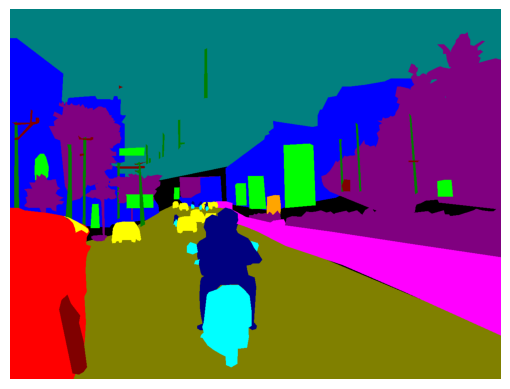

In [ ]:
def create_colored_mask(json_file, img_width, img_height, color_map):
    colored_mask = Image.new("RGB", (img_width, img_height), (0, 0, 0))

    with open(json_file, 'r') as f:
        data = json.load(f)

    for obj in data['objects']:
        label = obj['label']
        polygon = obj['polygon']

        if label in color_map:
            polygon = [(x, y) for x, y in polygon]
            draw = ImageDraw.Draw(colored_mask)
            draw.polygon(polygon, outline=color_map[label], fill=color_map[label])

    return np.array(colored_mask)

color_map = {
    'autorickshaw': (255, 0, 0),        # Red
    'billboard': (0, 255, 0),           # Green
    'building': (0, 0, 255),            # Blue
    'car': (255, 255, 0),               # Yellow
    'curb': (255, 0, 255),              # Magenta
    'motorcycle': (0, 255, 255),        # Cyan
    'obs-str-bar-fallback': (128, 0, 0),# Dark Red
    'pole': (0, 128, 0),                # Dark Green
    'rider': (0, 0, 128),               # Dark Blue
    'road': (128, 128, 0),              # Olive
    'sky': (0, 128, 128),               # Teal
    'vegetation': (128, 0, 128),        # Purple
    'vehicle fallback': (255, 165, 0)   # Orange
}

json_file_path = '/kaggle/input/idd-seg/IDD_Segmentation/gtFine/train/0/010515_gtFine_polygons.json'

with open(json_file_path, 'r') as f:
    data = json.load(f)
    img_width = data['imgWidth']
    img_height = data['imgHeight']

colored_mask = create_colored_mask(json_file_path, img_width, img_height, color_map)

plt.imshow(colored_mask)
plt.axis('off')  # Hide the axes
plt.show()

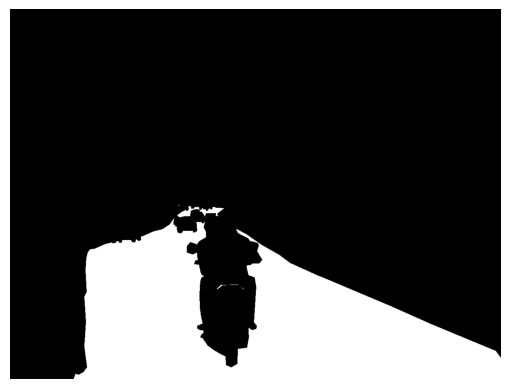

In [ ]:
def create_binary_mask(json_file, img_width, img_height):
    binary_mask = Image.new("RGB", (img_width, img_height), (0, 0, 0))

    with open(json_file, 'r') as f:
        data = json.load(f)

    road_color = (255, 255, 255)
    non_road_color = (0, 0, 0)

    road_labels = ['road']

    for obj in data['objects']:
        label = obj['label']
        polygon = obj['polygon']

        if label in road_labels:
            polygon = [(x, y) for x, y in polygon]
            draw = ImageDraw.Draw(binary_mask)
            draw.polygon(polygon, outline=road_color, fill=road_color)

    for obj in data['objects']:
        label = obj['label']
        polygon = obj['polygon']

        if label not in road_labels or label in ['drivable-fallback', 'parking']:
            polygon = [(x, y) for x, y in polygon]
            draw = ImageDraw.Draw(binary_mask)
            draw.polygon(polygon, outline=non_road_color, fill=non_road_color)

    return np.array(binary_mask)

json_file_path = '/kaggle/input/idd-seg/IDD_Segmentation/gtFine/train/0/010515_gtFine_polygons.json'

with open(json_file_path, 'r') as f:
    data = json.load(f)
    img_width = data['imgWidth']
    img_height = data['imgHeight']

binary_mask = create_binary_mask(json_file_path, img_width, img_height)

plt.imshow(binary_mask)
plt.axis('off')
plt.show()


Generating binary masks for all images in the dataset (road includes labels "road","drivable-fallback" and "parking", as per the information in the IDD paper):

In [ ]:
train_input_dir = '/kaggle/input/idd-seg/IDD_Segmentation/gtFine/train'
val_input_dir = '/kaggle/input/idd-seg/IDD_Segmentation/gtFine/val'
output_dir = '/kaggle/working/binary_masks'
os.makedirs(output_dir, exist_ok=True)

def create_binary_mask(json_file, img_width, img_height):
    mask = np.zeros((img_height, img_width), dtype=np.uint8)

    with open(json_file, 'r') as f:
        data = json.load(f)

    for obj in data['objects']:
        label = obj['label']
        polygon = obj['polygon']
        polygon = [(x, y) for x, y in polygon]

        img = Image.fromarray(mask)
        draw = ImageDraw.Draw(img)

        if label in ["road", "drivable-fallback", "parking"]:
            draw.polygon(polygon, outline=1, fill=1)
        else:
            draw.polygon(polygon, outline=0, fill=0)

        mask = np.array(img)

    return mask

def process_json_files(input_dir, dataset_type):
    json_files = []

    for subdir, dirs, files in os.walk(input_dir):
        for file in files:
            if file.endswith('_gtFine_polygons.json'):
                json_files.append(os.path.join(subdir, file))

    for json_file in tqdm(json_files, desc=f"Processing JSON files in {input_dir}", unit="file"):
        with open(json_file, 'r') as f:
            data = json.load(f)
            img_width = data['imgWidth']
            img_height = data['imgHeight']

        binary_mask = create_binary_mask(json_file, img_width, img_height)

        relative_path = os.path.relpath(os.path.dirname(json_file), input_dir)
        mask_output_dir = os.path.join(output_dir, dataset_type, relative_path)
        os.makedirs(mask_output_dir, exist_ok=True)

        mask_filename = os.path.basename(json_file).replace('_gtFine_polygons.json', '_binary_mask.png')
        mask_output_path = os.path.join(mask_output_dir, mask_filename)
        Image.fromarray(binary_mask * 255).save(mask_output_path)

process_json_files(train_input_dir, 'train')
process_json_files(val_input_dir, 'val')

print(f"Binary masks saved to {output_dir}/train and {output_dir}/val")

Processing JSON files in /kaggle/input/idd-seg/IDD_Segmentation/gtFine/train: 100%|██████████| 6993/6993 [12:08<00:00,  9.60file/s]
Processing JSON files in /kaggle/input/idd-seg/IDD_Segmentation/gtFine/val: 100%|██████████| 981/981 [01:32<00:00, 10.57file/s]

Binary masks saved to /kaggle/working/binary_masks/train and /kaggle/working/binary_masks/val


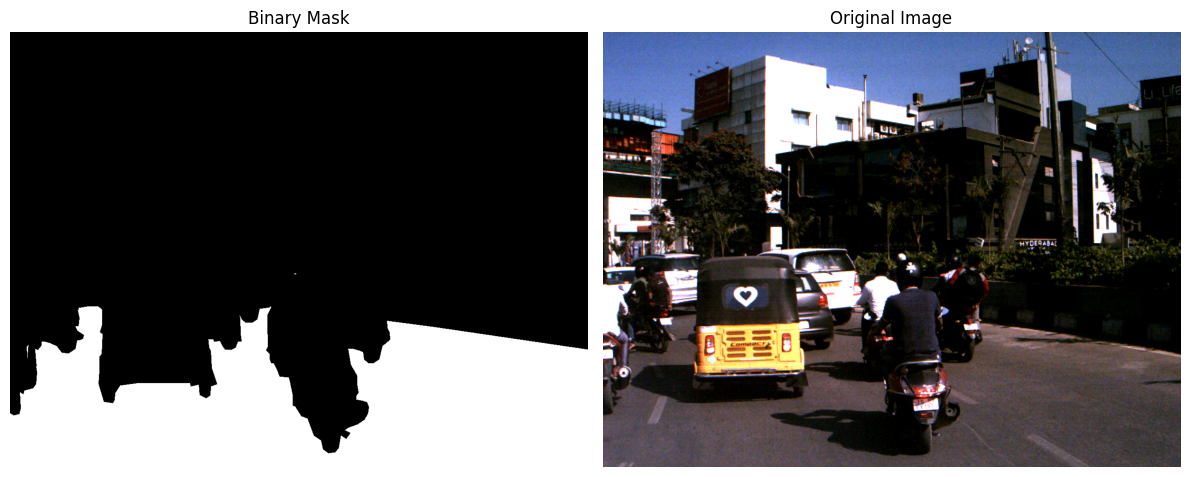

In [ ]:
mask_path = '/kaggle/working/binary_masks/train/0/005626_binary_mask.png'
image_path = '/kaggle/input/idd-seg/IDD_Segmentation/leftImg8bit/train/0/005626_leftImg8bit.png'

binary_mask = Image.open(mask_path)
image = Image.open(image_path)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(binary_mask, cmap='gray')
plt.title('Binary Mask')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.tight_layout()
plt.show()


The architecture is a U-Net that utilizes a pre-trained ResNet-50 encoder, enhancing its ability to extract rich features for image segmentation.

This design benefits from ResNet's residual connections, which help preserve detailed spatial information and enable the model to learn complex patterns more effectively. The symmetric down-sampling and up-sampling paths of U-Net ensure precise localization by merging low-level and high-level features through skip connections.

This integration of residual learning with the U-Net framework results in improved accuracy and robustness to unseen data.

In [ ]:
resnet = torchvision.models.resnet.resnet50(pretrained=True)

class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """

    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x


class Bridge(nn.Module):
    """
    This is the middle layer of the UNet which just consists of some
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)


class UpBlockForUNetWithResNet50(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        """

        :param up_x: this is the output from the previous up block
        :param down_x: this is the output from the down block
        :return: upsampled feature map
        """
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x


class UNetWithResnet50Encoder(nn.Module):
    DEPTH = 6

    def __init__(self, n_classes=2):
        super().__init__()
        resnet = torchvision.models.resnet.resnet50(pretrained=True)
        down_blocks = []
        up_blocks = []
        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        self.bridge = Bridge(2048, 2048)
        up_blocks.append(UpBlockForUNetWithResNet50(2048, 1024))
        up_blocks.append(UpBlockForUNetWithResNet50(1024, 512))
        up_blocks.append(UpBlockForUNetWithResNet50(512, 256))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=128 + 64, out_channels=128,
                                                    up_conv_in_channels=256, up_conv_out_channels=128))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=64 + 3, out_channels=64,
                                                    up_conv_in_channels=128, up_conv_out_channels=64))

        self.up_blocks = nn.ModuleList(up_blocks)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1, stride=1)

    def forward(self, x, with_output_feature_map=False):
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)

        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i == (UNetWithResnet50Encoder.DEPTH - 1):
                continue
            pre_pools[f"layer_{i}"] = x

        x = self.bridge(x)

        for i, block in enumerate(self.up_blocks, 1):
            key = f"layer_{UNetWithResnet50Encoder.DEPTH - 1 - i}"
            x = block(x, pre_pools[key])
        output_feature_map = x
        x = self.out(x)
        del pre_pools
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x

model = UNetWithResnet50Encoder().cuda()
# inp = torch.rand((2, 3, 512, 512)).cuda()
# out = model(inp)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s] 


In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = self._get_image_paths(img_dir)

    def _get_image_paths(self, dir_path):
        image_paths = []
        for subdir, _, files in os.walk(dir_path):
            for file in files:
                if file.endswith('_leftImg8bit.png'):
                    image_paths.append(os.path.join(subdir, file))
        return image_paths

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        mask_path = os.path.join(self.mask_dir, os.path.relpath(img_path, self.img_dir).replace('_leftImg8bit.png', '_binary_mask.png'))

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # grayscale

        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)

        return img, mask


In [ ]:
def dice_score(preds, targets, smooth=1e-6):
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    return (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

def iou_score(preds, targets, smooth=1e-6):
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return (intersection + smooth) / (union + smooth)

In [ ]:
num_epochs = 1
batch_size = 2
learning_rate = 1e-4
train_img_dir = '/kaggle/input/idd-seg/IDD_Segmentation/leftImg8bit/train'
val_img_dir = '/kaggle/input/idd-seg/IDD_Segmentation/leftImg8bit/val'
train_mask_dir = '/kaggle/working/binary_masks/train'
val_mask_dir = '/kaggle/working/binary_masks/val'

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

train_dataset = SegmentationDataset(train_img_dir, train_mask_dir, transform)
val_dataset = SegmentationDataset(val_img_dir, val_mask_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = UNetWithResnet50Encoder(n_classes=1).cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_dice_scores = []


In [ ]:
torch.cuda.empty_cache()

Running the model for 1 epoch was sufficient, as extending training to 3 epochs led to a decrease in loss but also degradation in output quality. This behavior suggests that the model began overfitting the training data; it learned to minimize the loss by memorizing patterns rather than generalizing to unseen data. Consequently, while the loss improved, the model's performance on validation data worsened, resulting in lower accuracy and poorer outputs.

Since the validation loss and accuracy were only assessed after 1 epoch, the plots do not provide useful insights into the model's performance over time. The lack of multiple epochs limits the ability to observe trends in generalization, making those metrics ineffective for evaluating the model's true capabilities.

Epoch 1/1: 100%|██████████| 3497/3497 [43:27<00:00,  1.34batch/s, loss=0.118]


Epoch [1/1], Loss: 0.1180, Val Dice: 0.9437


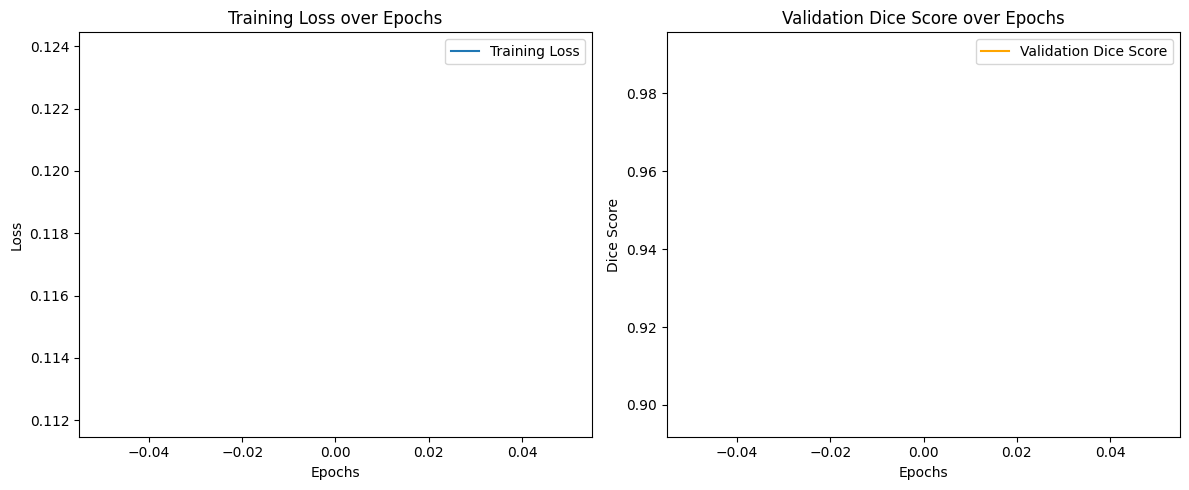

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

    for imgs, masks in pbar:
        imgs = imgs.cuda()
        masks = masks.cuda()

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix(loss=running_loss / (pbar.n + 1))

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    model.eval()
    val_dice = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.cuda()
            masks = masks.cuda()
            outputs = model(imgs)
            preds = torch.sigmoid(outputs) > 0.5  # Thresholding
            val_dice += dice_score(preds.float(), masks.float()).item()

    avg_val_dice = val_dice / len(val_loader)
    val_dice_scores.append(avg_val_dice)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Val Dice: {avg_val_dice:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_dice_scores, label='Validation Dice Score', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.title('Validation Dice Score over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), '/kaggle/working/trained_model.pth')

/tmp/ipykernel_36/781129966.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/trained_model.pth'))


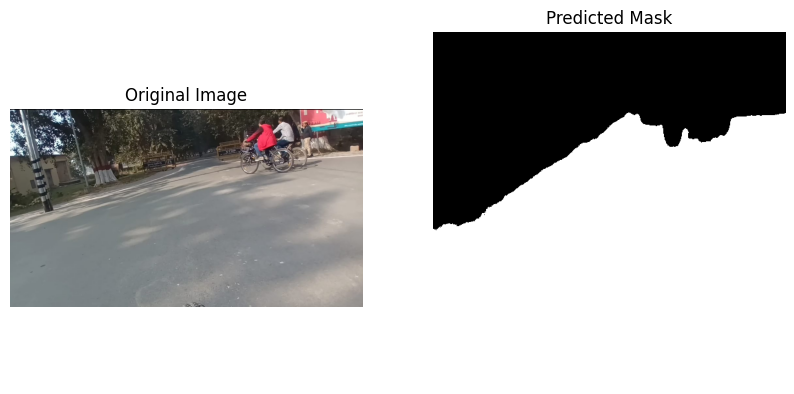

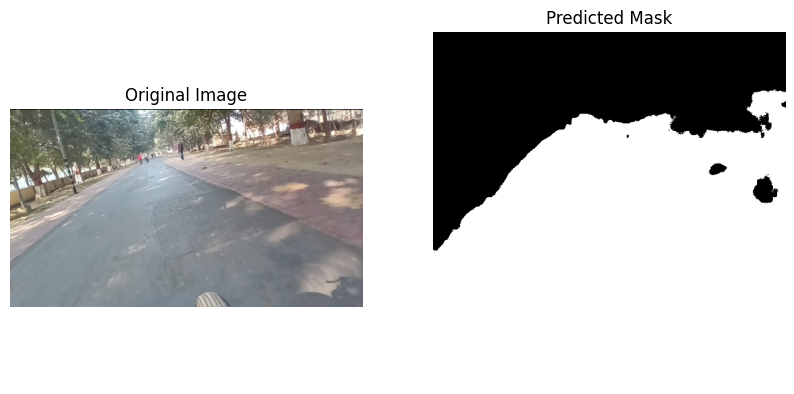

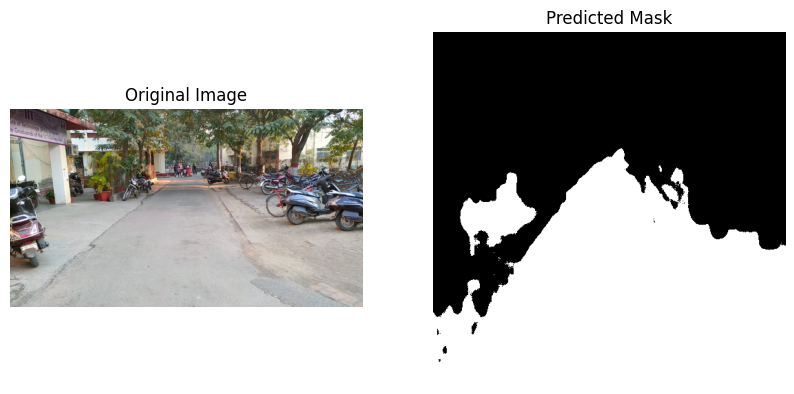

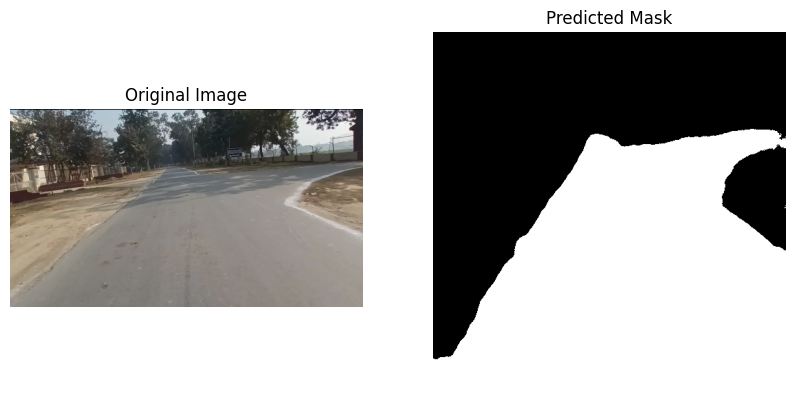

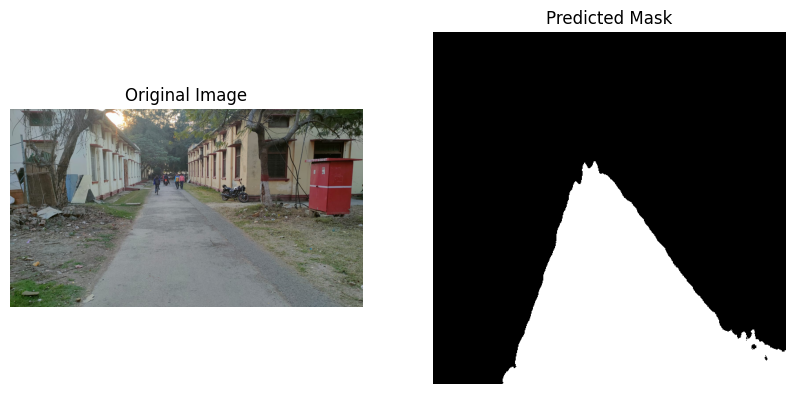

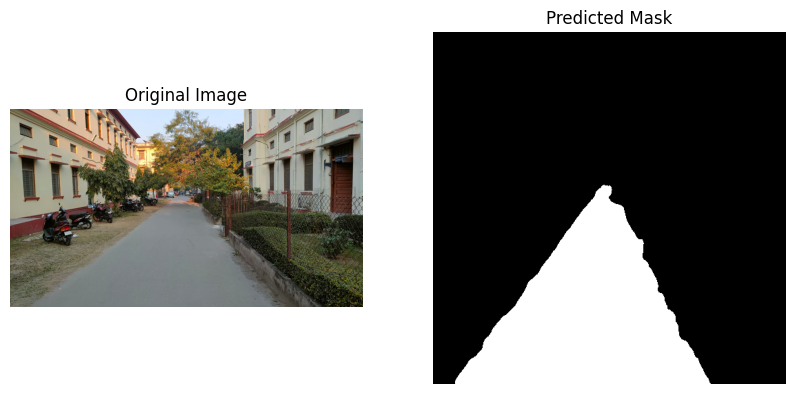

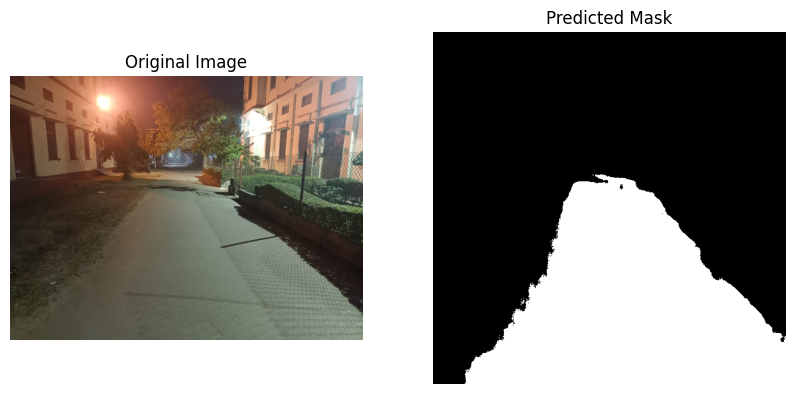

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

def load_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img_tensor = preprocess(img).unsqueeze(0)
    return img, img_tensor

def predict(model, img_tensor):
    model.eval()
    with torch.no_grad():
        img_tensor = img_tensor.cuda()
        output = model(img_tensor)
        output = torch.sigmoid(output)
        mask = output.squeeze().cpu().numpy()
        mask = (mask > 0.5).astype(np.uint8)
        if mask.ndim > 2:
            mask = mask[0]
    return mask

def visualize_results(img, mask):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img)
    ax[0].axis('off')
    ax[0].set_title('Original Image')

    mask_visual = mask * 255
    ax[1].imshow(mask_visual, cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('Predicted Mask')

    plt.show()

model = UNetWithResnet50Encoder()
model.out = torch.nn.Conv2d(64, 1, kernel_size=(1, 1))

model = model.cuda()
model.load_state_dict(torch.load('/kaggle/working/trained_model.pth'))

test_image_dir = '/kaggle/input/iit-bhu-roads/'

image_filenames = ['1.jpeg', '2.jpeg', 'P1.jpeg', 'P18.jpeg', 'P2.jpeg', 'P9.jpeg', 'n1.jpeg']

for img_filename in image_filenames:
    img_path = os.path.join(test_image_dir, img_filename)
    img, img_tensor = load_image(img_path)
    mask = predict(model, img_tensor)
    visualize_results(img, mask)

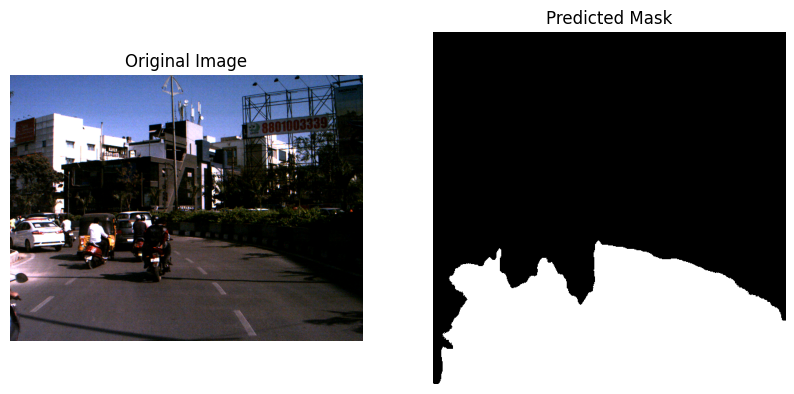

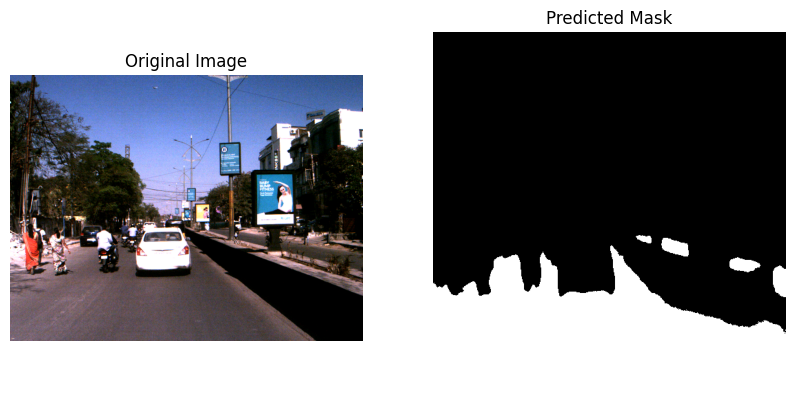

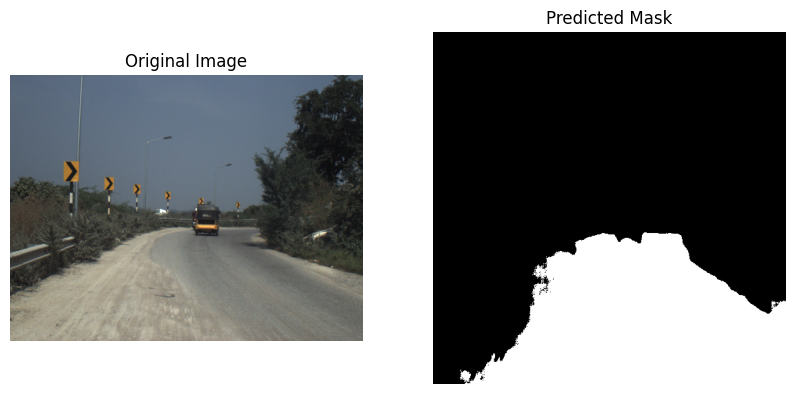

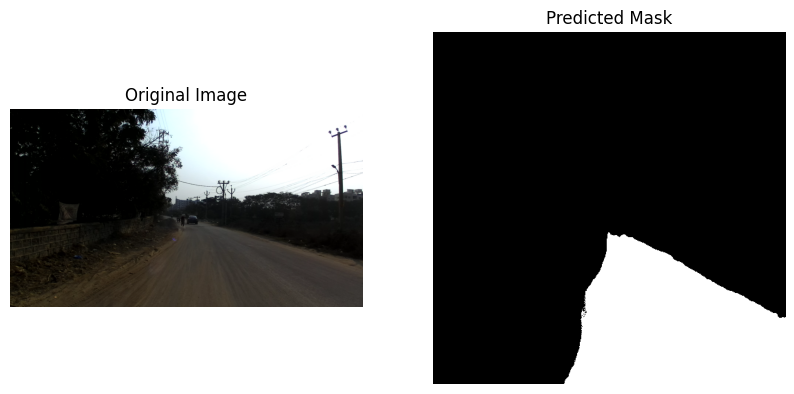

In [ ]:
def test_outputs(path):
    img, img_tensor = load_image(path)
    mask = predict(model, img_tensor)
    visualize_results(img, mask)

test_outputs('/kaggle/input/idd-seg/IDD_Segmentation/leftImg8bit/train/0/005506_leftImg8bit.png')
test_outputs('/kaggle/input/idd-seg/IDD_Segmentation/leftImg8bit/train/0/013649_leftImg8bit.png')
test_outputs('/kaggle/input/idd-seg/IDD_Segmentation/leftImg8bit/test/35/002552_leftImg8bit.png')
test_outputs('/kaggle/input/idd-seg/IDD_Segmentation/leftImg8bit/test/27/025085_leftImg8bit.png')


In [ ]:
# import torch
# import torch.nn as nn
# from torchvision import models

# class UNetResNet(nn.Module):
#     def __init__(self, n_classes):
#         super(UNetResNet, self).__init__()

#         resnet = models.resnet34(pretrained=True)
#         self.encoder = nn.Sequential(
#             resnet.conv1,
#             resnet.bn1,
#             resnet.relu,
#             resnet.maxpool,
#             resnet.layer1,
#             resnet.layer2,
#             resnet.layer3,
#             resnet.layer4
#         )

#         # Decoder: U-Net style decoder with transpose convolutions
#         self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)  # Upsample to 256 channels
#         self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # Upsample to 128 channels
#         self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)   # Upsample to 64 channels
#         self.up4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)    # Upsample to 32 channels
#         self.up5 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)    # New: Upsample to 16 channels

#         self.conv1x1 = nn.Conv2d(16, n_classes, kernel_size=1)  # Final 1x1 conv to n_classes (binary)

#     def forward(self, x):
#         # Encoder path (ResNet encoder)
#         x1 = self.encoder[0](x)  # conv1 -> output has 64 channels
#         x2 = self.encoder[1](x1)  # bn1 -> output has 64 channels
#         x3 = self.encoder[2](x2)  # relu -> output has 64 channels
#         x4 = self.encoder[3](x3)  # maxpool -> output has 64 channels
#         x5 = self.encoder[4](x4)  # layer1 -> output has 64 channels
#         x6 = self.encoder[5](x5)  # layer2 -> output has 128 channels
#         x7 = self.encoder[6](x6)  # layer3 -> output has 256 channels
#         x8 = self.encoder[7](x7)  # layer4 -> output has 512 channels

#         # Decoder path (U-Net decoder)
#         d1 = self.up1(x8)  # First upsample: output should have 256 channels
#         d2 = self.up2(d1)  # Second upsample: output should have 128 channels
#         d3 = self.up3(d2)  # Third upsample: output should have 64 channels
#         d4 = self.up4(d3)  # Fourth upsample: output should have 32 channels
#         d5 = self.up5(d4)  # New: Fifth upsample to reach input size

#         output = self.conv1x1(d5)  # Final 1x1 conv to map to n_classes (binary in your case)
#         return output


In [ ]:
# import os
# from torch.utils.data import Dataset
# from PIL import Image

# class IDDDataset(Dataset):
#     def __init__(self, img_dir, mask_dir, transform=None, mask_transform=None):
#         self.img_dir = img_dir
#         self.mask_dir = mask_dir
#         self.transform = transform
#         self.mask_transform = mask_transform
#         self.images = self._get_images(self.img_dir)  # Collect all image paths

#     def _get_images(self, root_dir):
#         """ Recursively collect image file paths from subdirectories """
#         image_files = []
#         for subdir, _, files in os.walk(root_dir):
#             for file in files:
#                 if file.endswith('.png'):  # Assuming images are .png
#                     image_files.append(os.path.join(subdir, file))
#         return image_files

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         img_path = self.images[idx]
#         # Construct the corresponding mask path
#         relative_path = os.path.relpath(img_path, self.img_dir)  # Get the relative path of the image
#         mask_path = os.path.join(self.mask_dir, relative_path.replace('_leftImg8bit.png', '_binary_mask.png'))

#         image = Image.open(img_path).convert("RGB")
#         mask = Image.open(mask_path).convert("L")  # Binary mask

#         if self.transform:
#             image = self.transform(image)
#         if self.mask_transform:
#             mask = self.mask_transform(mask)

#         return image, mask


In [ ]:
# from torchvision import transforms

# # Define image and mask transformations
# image_transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# mask_transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.ToTensor()
# ])

# # Dataset and DataLoader for train and val sets
# train_dataset = IDDDataset(img_dir='/kaggle/input/idd-seg/IDD_Segmentation/leftImg8bit/train',
#                            mask_dir='/kaggle/working/binary_masks/train',
#                            transform=image_transform,
#                            mask_transform=mask_transform)

# val_dataset = IDDDataset(img_dir='/kaggle/input/idd-seg/IDD_Segmentation/leftImg8bit/val',
#                          mask_dir='/kaggle/working/binary_masks/val',
#                          transform=image_transform,
#                          mask_transform=mask_transform)

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8)


In [ ]:
# # Initialize model, loss function, and optimizer
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = UNetResNet(n_classes=1)  # Binary segmentation
# model = model.to(device)

# criterion = nn.BCEWithLogitsLoss()  # Suitable for binary segmentation
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
# from tqdm import tqdm  # Import tqdm for progress bar

# def train_model(model, train_loader, val_loader, num_epochs=25):
#     train_losses = []
#     val_losses = []

#     for epoch in range(num_epochs):
#         # Training Phase
#         model.train()
#         running_loss = 0.0

#         # Add tqdm for tracking training batch progress
#         train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", unit="batch")

#         for images, masks in train_loader_tqdm:
#             images = images.to(device)
#             masks = masks.to(device)

#             optimizer.zero_grad()

#             outputs = model(images)
#             loss = criterion(outputs, masks)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()
#             train_loader_tqdm.set_postfix({"Loss": loss.item()})  # Update tqdm bar with current batch loss

#         epoch_train_loss = running_loss / len(train_loader)
#         train_losses.append(epoch_train_loss)
#         print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_train_loss:.4f}")

#         # Validation Phase
#         model.eval()
#         val_loss = 0.0

#         # Add tqdm for tracking validation batch progress
#         val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", unit="batch")

#         with torch.no_grad():
#             for images, masks in val_loader_tqdm:
#                 images = images.to(device)
#                 masks = masks.to(device)

#                 outputs = model(images)
#                 loss = criterion(outputs, masks)

#                 val_loss += loss.item()
#                 val_loader_tqdm.set_postfix({"Loss": loss.item()})  # Update tqdm bar with current batch loss

#         epoch_val_loss = val_loss / len(val_loader)
#         val_losses.append(epoch_val_loss)
#         print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {epoch_val_loss:.4f}")

#     return train_losses, val_losses

In [ ]:
# train_model(model, train_loader, val_loader, num_epochs=25)


In [ ]:
# !pip install -q segmentation_models_pytorch

In [ ]:
# import os
# import random
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms
# import albumentations as A
# from tqdm import tqdm
# from PIL import Image

# class IDDDataset(Dataset):
#     def __init__(self, img_dir, mask_dir, transform=None):
#         self.img_dir = img_dir
#         self.mask_dir = mask_dir
#         self.transform = transform
#         self.images = []
#         self.masks = []

#         # Traverse through the image directory
#         for subdir, _, files in os.walk(img_dir):
#             for file in files:
#                 if file.endswith('_gtFine_polygons.json'):
#                     img_name = file.replace('_gtFine_polygons.json', '.png')  # Modify if necessary
#                     img_path = os.path.join(subdir, img_name)

#                     # Determine the corresponding mask file path
#                     mask_subdir = os.path.relpath(subdir, img_dir)  # Get relative subdirectory path
#                     mask_path = os.path.join(mask_dir, mask_subdir, img_name.replace('.png', '_binary_mask.png'))

#                     # Debug prints
#                     print(f"Checking image: {img_path}")
#                     print(f"Expected mask path: {mask_path}")

#                     if os.path.exists(mask_path):
#                         self.images.append(img_path)
#                         self.masks.append(mask_path)
#                     else:
#                         print(f"Mask not found for image: {img_name}")

#         print(f"Total images: {len(self.images)}, Total masks: {len(self.masks)}")

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         img_path = self.images[idx]
#         mask_path = self.masks[idx]

#         image = Image.open(img_path).convert("RGB")
#         mask = Image.open(mask_path).convert("L")  # Binary mask

#         if self.transform:
#             image = self.transform(image)
#             mask = self.transform(mask)

#         return image, mask


# # Augmentation functions
# def get_training_augmentation():
#     return A.Compose([
#         A.RandomCrop(height=256, width=256),
#         A.OneOf([
#             A.HorizontalFlip(p=1),
#             A.VerticalFlip(p=1),
#             A.RandomRotate90(p=1),
#         ], p=0.75),
#     ])

# def get_validation_augmentation():
#     return A.Compose([
#         A.PadIfNeeded(min_height=256, min_width=256, border_mode=cv2.BORDER_CONSTANT, value=0),
#     ])

# # Define the UNet model
# class UNetResNet(nn.Module):
#     def __init__(self, n_classes):
#         super(UNetResNet, self).__init__()
#         resnet = models.resnet34(pretrained=True)
#         self.encoder = nn.Sequential(
#             resnet.conv1,
#             resnet.bn1,
#             resnet.relu,
#             resnet.maxpool,
#             resnet.layer1,
#             resnet.layer2,
#             resnet.layer3,
#             resnet.layer4
#         )
#         self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
#         self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
#         self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
#         self.up4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
#         self.conv1x1 = nn.Conv2d(32, n_classes, kernel_size=1)

#     def forward(self, x):
#         x1 = self.encoder[0](x)
#         x2 = self.encoder[1](x1)
#         x3 = self.encoder[2](x2)
#         x4 = self.encoder[3](x3)
#         x5 = self.encoder[4](x4)

#         d1 = self.up1(x5)
#         d2 = self.up2(d1)
#         d3 = self.up3(d2)
#         d4 = self.up4(d3)

#         output = self.conv1x1(d4)
#         return output

# # Training function
# def train_model(model, train_loader, val_loader, num_epochs):
#     criterion = nn.BCEWithLogitsLoss()  # For binary segmentation
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

#     train_losses, val_losses = [], []

#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0

#         for images, masks in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{num_epochs}", unit="batch"):
#             images = images.to(device)
#             masks = masks.to(device)

#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, masks)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()

#         train_loss = running_loss / len(train_loader)
#         train_losses.append(train_loss)
#         print(f"Train Loss: {train_loss:.4f}")

#         # Validation step
#         model.eval()
#         val_loss = 0.0
#         with torch.no_grad():
#             for images, masks in val_loader:
#                 images = images.to(device)
#                 masks = masks.to(device)
#                 outputs = model(images)
#                 loss = criterion(outputs, masks)
#                 val_loss += loss.item()

#         val_loss /= len(val_loader)
#         val_losses.append(val_loss)
#         print(f"Validation Loss: {val_loss:.4f}")

#     return train_losses, val_losses

# # Paths
# train_img_dir = '/kaggle/input/idd-seg/IDD_Segmentation/leftImg8bit/train'
# train_mask_dir = '/kaggle/working/binary_masks/train'
# val_img_dir = '/kaggle/input/idd-seg/IDD_Segmentation/leftImg8bit/val'
# val_mask_dir = '/kaggle/working/binary_masks/val'

# # Define transforms
# image_transform = get_training_augmentation()
# mask_transform = get_validation_augmentation()

# # Create datasets and dataloaders
# train_dataset = IDDDataset(img_dir=train_img_dir, mask_dir=train_mask_dir, transform=image_transform)
# val_dataset = IDDDataset(img_dir=val_img_dir, mask_dir=val_mask_dir, transform=mask_transform)

# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=8)

# # Device setup
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Model instantiation
# model = UNetResNet(n_classes=1).to(device)

# # Train the model
# num_epochs = 10
# train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs)

# # Plotting training and validation losses
# plt.figure(figsize=(20, 8))
# plt.plot(train_losses, label='Train Loss', lw=3)
# plt.plot(val_losses, label='Validation Loss', lw=3)
# plt.xlabel('Epochs', fontsize=20)
# plt.ylabel('Loss', fontsize=20)
# plt.title('Loss Plot', fontsize=20)
# plt.legend(loc='best', fontsize=16)
# plt.grid()
# plt.show()
